Spring Mass Damper System
=========================

Description of the problem
--------------------------

<img src="smdd.png" width="400" class="center"/>

Consider the dynamics of a damped spring mass system governed by a second order differential equation given by

\begin{align}
m\ddot{x}(t) + c\dot{x}(t) + kx(t) = F(t)
\end{align}

where $m, c$ and $k$ are the mass, damping and spring constants. Variable $x(t)$ represents the
displacement of the mass from the equilibrium and the external forcing is denoted by $F(t)$.
In a first-order state-space form with $x_1 = x$ and $x_2 = \dot{x}$, the continuous-time model
(including its measurement equation) becomes

\begin{align}
\dot{\boldsymbol{x}}(t) &= \begin{bmatrix} \dot{x}_1(t)\\ \dot{x}_2(t) \end{bmatrix} =
\begin{bmatrix} 0 & 1\\ -\dfrac{k}{m} & -\dfrac{c}{m} \end{bmatrix}
\begin{bmatrix} x_1(t)\\ x_2(t) \end{bmatrix} +
\begin{bmatrix} 0 \\ 1 \end{bmatrix}F(t) =
A_c\boldsymbol{x}(t) + B_cu(t),\\
\boldsymbol{y}(t) &= \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\begin{bmatrix} x_1(t)\\ x_2(t) \end{bmatrix} =
C\boldsymbol{x}(t) + Du(t),\\
\end{align}
where
\begin{align}
A_c = \begin{bmatrix} 0 & 1\\ -\dfrac{k}{m} & -\dfrac{c}{m} \end{bmatrix}, \quad
B_c = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad
C = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}, \quad
D = \begin{bmatrix} 0 \\ 0 \end{bmatrix}.
\end{align}
Assuming that $u(\tau)$ is constant between sample times, i.e.
$u(\tau) = u(k\Delta t)$ for $k\Delta t\leq \tau < (k+1)\Delta t$, let's define
the discrete-time model
\begin{align}
\boldsymbol{x}_{k+1} &= A\boldsymbol{x}_{k} + Bu_k,\\
\boldsymbol{y}_{k} &= C\boldsymbol{x}_{k} + Du_k,
\end{align}
where
\begin{align}
A = e^{A_c\Delta t}, \quad
B_c = \int_{0}^{\Delta t}e^{A_ct}\mathrm{d}tB_c.
\end{align}
Given a time-history of $\boldsymbol{x}(t_k)$ and $u(t_k)$, the objective is to find a realization
$(\hat{A}, \hat{B}, \hat{C}, \hat{D})$ of the discrete-time linear model.

Code
--------------------------

The code below shows how to use the python systemID package to find a linear representation
of the dynamics of the damped spring mass system.

First, import all necessary packages.

In [9]:
import systemID as sysID

import numpy as np
import scipy.linalg as LA

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams.update({"text.usetex": True, "font.family": "sans-serif", "font.serif": ["Computer Modern Roman"]})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

\
&nbsp;
\
&nbsp;
Define the parameters of the study. Data is collected at a frequency of 10Hz.

In [10]:
m = 1
c = 0.1
k = 1

state_dimension = 2
input_dimension = 1
output_dimension = 2

frequency = 10
dt = 1/frequency

\
&nbsp;
\
&nbsp;
Create the continuous and then discrete-time system matrices.
Create the associated discrete linear model.

In [11]:
Ac = np.array([[0, 1], [-k/m, -c/m]])
Bc = np.array([[0], [1]])

(Ad, Bd) = sysID.continuous_to_discrete_matrices(dt, Ac, Bc=Bc)

def A(t):
    return Ad
def B(t):
    return Bd
def C(t):
    return np.eye(state_dimension)
def D(t):
    return np.zeros([output_dimension, input_dimension])

x0 = np.zeros(state_dimension)
true_system = sysID.discrete_linear_model(frequency, x0, A, B=B, C=C, D=D)


\
&nbsp;
\
&nbsp;
Generate an input signal for 5 seconds.

In [12]:
total_time_training = 5
number_steps_training = int(total_time_training * frequency + 1)

input_training = sysID.discrete_signal(frequency=frequency, data=np.random.randn(number_steps_training))
output_training = sysID.propagate(input_training, true_system)[0]


\
&nbsp;
\
&nbsp;
Identification. The observer order is chosen to be 10. Parameters $p$ and $q$ for the
Hankel matrix are chosen to be $p=q=20$. The number of Markov parameters calculated is chosen
to be 50, enough to populate the Hankel matrix. Singular values are plotted to determine
the order of the system.

Error OKID = 2.8876338787766992e-15


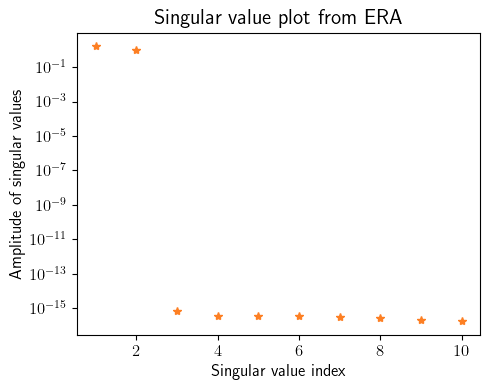

In [13]:
okid_ = sysID.okid_with_observer([input_training], [output_training], observer_order=10, number_of_parameters=50)

p = 20
q = p
era_ = sysID.era(okid_.markov_parameters, state_dimension=state_dimension, p=p, q=q)

fig = plt.figure(num=1, figsize=[5, 4])

ax = fig.add_subplot(1, 1, 1)
ax.semilogy(np.linspace(1, 10, 10), np.diag(era_.Sigma)[0:10], '*', color=(253/255, 127/255, 35/255))
plt.ylabel(r'Amplitude of singular values', fontsize=12)
plt.xlabel(r'Singular value index', fontsize=12)
plt.title(r'Singular value plot from ERA', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

x0_id = np.zeros(state_dimension)
identified_system = sysID.discrete_linear_model(frequency, x0_id, era_.A, B=era_.B, C=era_.C, D=era_.D)


\
&nbsp;
\
&nbsp;
Testing is accomplished using a sinusoidal signal for 20 seconds.

In [14]:
total_time_testing = 20
number_steps_testing = int(total_time_testing * frequency + 1)
tspan_testing = np.linspace(0, total_time_testing, number_steps_testing)

input_testing = sysID.discrete_signal(frequency=frequency, data=np.sin(3 * tspan_testing))
output_testing_true = sysID.propagate(input_testing, true_system)[0]
output_testing_identified = sysID.propagate(input_testing, identified_system)[0]


\
&nbsp;
\
&nbsp;
Plotting.

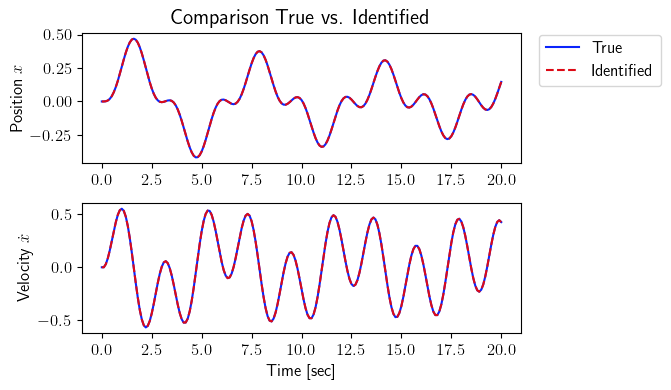

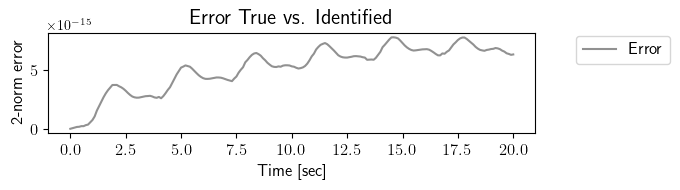

In [15]:
fig = plt.figure(num=2, figsize=[7, 4])

ax = fig.add_subplot(2, 1, 1)
ax.plot(tspan_testing, output_testing_true.data[0, :], color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing, output_testing_identified.data[0, :], '--', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Position $x$', fontsize=12)
plt.title(r'Comparison True vs. Identified', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.05), ncol=1, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = fig.add_subplot(2, 1, 2)
ax.plot(tspan_testing, output_testing_true.data[1, :], color=(11/255, 36/255, 251/255))
ax.plot(tspan_testing, output_testing_identified.data[1, :], '--', color=(221/255, 10/255, 22/255))
plt.xlabel(r'Time [sec]', fontsize=12)
plt.ylabel(r'Velocity $\dot{x}$', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


fig = plt.figure(num=3, figsize=[7, 2])

ax = fig.add_subplot(1, 1, 1)
ax.plot(tspan_testing, LA.norm(output_testing_true.data - output_testing_identified.data, axis=0), color=(145/255, 145/255, 145/255), label=r'Error')
plt.ylabel(r'2-norm error', fontsize=12)
plt.xlabel(r'Time [sec]', fontsize=12)
plt.title(r'Error True vs. Identified', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.05), ncol=1, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


\
&nbsp;
\
&nbsp;
Eigenvalues of the true and identified models are compared.

True eigenvalues: [0.99005398+0.09921166j 0.99005398-0.09921166j]
Identified eigenvalues: [0.99005398+0.09921166j 0.99005398-0.09921166j]


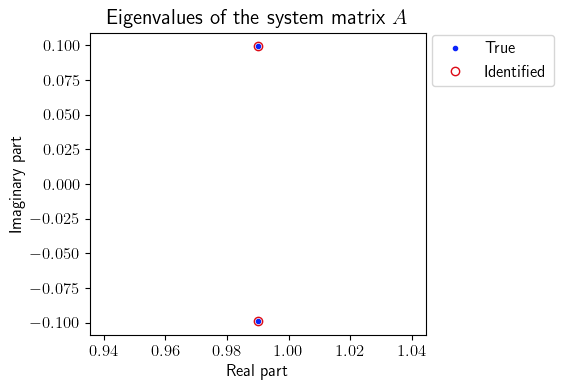

In [16]:
ev_true = LA.eig(A(0))[0]
ev_identified = LA.eig(era_.A(0))[0]
print('True eigenvalues:', ev_true)
print('Identified eigenvalues:', ev_identified)

fig = plt.figure(num=4, figsize=[6, 4])

ax = fig.add_subplot(1, 1, 1)
ax.plot(np.real(ev_true), np.imag(ev_true), '.', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(np.real(ev_identified), np.imag(ev_identified), 'o', mfc='none', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Imaginary part', fontsize=12)
plt.xlabel(r'Real part', fontsize=12)
plt.title(r'Eigenvalues of the system matrix $A$', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.02), ncol=1, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()